# 농산물 가격 예측 모델 개선


## 목차
1. 데이터 설명
2. 데이터 로드 및 탐색적 데이터 분석 (EDA)
3. 기존 모델 학습 및 평가 (LSTM)
4. 개선된 모델 구현 및 평가 (LSTM)
5. 성능 비교 및 결론


## 1. 데이터 설명

<br/>

이 프로젝트에서는 농산물의 가격을 예측하기 위해 다양한 데이터셋을 사용함. 사용된 데이터셋은 다음과 같음:
- `train.csv`: 학습 데이터
- `test.csv`: 테스트 데이터
- `sample_submission.csv`: 제출 파일 형식
- `international_trade.csv`: 국제 무역 데이터

#### 데이터셋 컬럼 설명
1. **train.csv**:
    - `ID`: 데이터 식별자
    - `timestamp`: 날짜
    - `item`: 품목
    - `corporation`: 법인명
    - `location`: 위치
    - `supply(kg)`: 공급량 (kg)
    - `price(원/kg)`: 가격 (원/kg)
2. **test.csv**:
    - `ID`: 데이터 식별자
    - `timestamp`: 날짜
    - `item`: 품목
    - `corporation`: 법인명
    - `location`: 위치
    - `supply(kg)`: 공급량 (kg)
3. **international_trade.csv**:
    - 다양한 국가의 무역 관련 데이터
4. **sample_submission.csv**:
    - 제출 형식 샘플 파일


## 2. 데이터 로드 및 탐색적 데이터 분석 (EDA)


각 데이터셋의 첫 5행을 확인하여 데이터의 구조와 내용을 파악함.


### 데이터 로드 및 확인

In [2]:
# 데이터 로드 및 확인

import pandas as pd
import numpy as np

# 데이터 로드
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
submission = pd.read_csv("/content/sample_submission.csv")
international = pd.read_csv("/content/international_trade.csv")

# 데이터 확인
print("Train 데이터셋의 처음 5행:")
print(train.head())

print("\nTest 데이터셋의 처음 5행:")
print(test.head())

print("\nInternational 데이터셋의 처음 5행:")
print(international.head())

Train 데이터셋의 처음 5행:
                ID   timestamp item corporation location  supply(kg)  \
0  TG_A_J_20190101  2019-01-01   TG           A        J         0.0   
1  TG_A_J_20190102  2019-01-02   TG           A        J         0.0   
2  TG_A_J_20190103  2019-01-03   TG           A        J     60601.0   
3  TG_A_J_20190104  2019-01-04   TG           A        J     25000.0   
4  TG_A_J_20190105  2019-01-05   TG           A        J     32352.0   

   price(원/kg)  
0          0.0  
1          0.0  
2       1728.0  
3       1408.0  
4       1250.0  

Test 데이터셋의 처음 5행:
                ID   timestamp item corporation location
0  TG_A_J_20230304  2023-03-04   TG           A        J
1  TG_A_J_20230305  2023-03-05   TG           A        J
2  TG_A_J_20230306  2023-03-06   TG           A        J
3  TG_A_J_20230307  2023-03-07   TG           A        J
4  TG_A_J_20230308  2023-03-08   TG           A        J

International 데이터셋의 처음 5행:
        기간                        품목명   수출 중량  수출 금액    수

### 결측치 확인

In [3]:
# 결측치 확인

print("\nTrain 데이터셋의 결측치:")
print(train.isnull().sum())

print("\nTest 데이터셋의 결측치:")
print(test.isnull().sum())

print("\nInternational 데이터셋의 결측치:")
print(international.isnull().sum())


Train 데이터셋의 결측치:
ID             0
timestamp      0
item           0
corporation    0
location       0
supply(kg)     0
price(원/kg)    0
dtype: int64

Test 데이터셋의 결측치:
ID             0
timestamp      0
item           0
corporation    0
location       0
dtype: int64

International 데이터셋의 결측치:
기간       0
품목명      0
수출 중량    0
수출 금액    0
수입 중량    0
수입 금액    0
무역수지     0
dtype: int64


모든 데이터셋의 결측치 확인 결과

모든 데이터셋의 결측치를 확인한 결과, 모든 열에 결측치가 없음을 알 수 있음.

### 데이터 통계량 확인

In [4]:
# 데이터 통계량 확인

print("\nTrain 데이터셋의 통계량:")
print(train.describe())


Train 데이터셋의 통계량:
         supply(kg)   price(원/kg)
count  5.939700e+04  59397.000000
mean   1.189453e+04   1131.680674
std    5.226400e+04   2029.941445
min    0.000000e+00      0.000000
25%    0.000000e+00      0.000000
50%    0.000000e+00      0.000000
75%    3.800000e+03   1519.000000
max    1.222800e+06  20909.000000


**Train 데이터셋의 통계량 확인 결과**

<br/>

*   Train 데이터셋의 공급량과 가격 데이터는 큰 변동성을 가지며, 많은 항목들이 공급량과 가격이 0인 경우가 많음

*   75% 사분위수는 supply(kg)가 3,800 kg, price(원/kg)가 1,519 원/kg로, 상위 25%의 값들이 상대적으로 크다는 것을 알 수 있음

*  supply(kg)와 price(원/kg) 값이 큰 변동성을 가질 수 있음을 시사함.



### 데이터 시각화

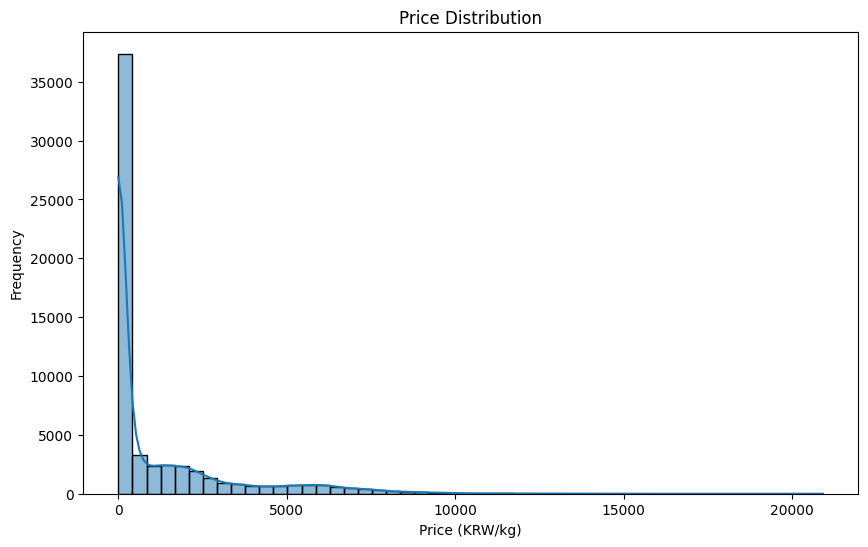

In [14]:
# 데이터 시각화

import matplotlib.pyplot as plt
import seaborn as sns

# 가격 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(train['price(원/kg)'], bins=50, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price (KRW/kg)')
plt.ylabel('Frequency')
plt.show()

### 분포 그래프 분석

#### 그래프 설명
위의 그래프는 `Train` 데이터셋의 `price(원/kg)` 열에 대한 가격 분포를 보여줌. 가격은 한국 원(KRW) 단위로 측정되었으며, x축은 가격, y축은 빈도수를 나타냄.

#### 분석 결과

1. **가격 분포의 집중**:
    - 그래프에서 볼 수 있듯이, 가격이 0인 데이터 포인트가 매우 많이 분포하고 있음. 이는 공급량이 0이거나 가격 정보가 누락된 경우일 수 있음.
    - 대다수의 데이터 포인트는 저가 구간에 몰려 있으며, 특히 0에 매우 높은 빈도수가 집중되어 있음.

2. **긴 꼬리 현상**:
    - 그래프는 오른쪽으로 긴 꼬리를 가지고 있으며, 이는 고가 데이터 포인트가 존재하지만 빈도가 매우 낮음을 나타냄.
    - 대부분의 가격이 0에서 5,000 KRW/kg 사이에 분포되어 있으며, 그 이후의 가격은 상대적으로 적음.

3. **가격 변동성**:
    - 가격 분포의 표준편차가 크다는 것을 알 수 있음. 이는 가격 데이터의 변동성이 크다는 것을 의미함.
    - 저가부터 고가까지 넓은 범위의 가격이 존재함.

#### 결론

- **데이터 전처리 필요성**:
    - 가격이 0인 데이터 포인트에 대한 추가적인 분석이 필요함. 이 데이터들이 실제로 의미 있는 값인지, 아니면 오류나 누락된 데이터인지를 고려해야 함.
    - 가격 변동성이 큰 데이터의 특성을 고려하여 모델링 시 적절한 스케일링이나 변환을 적용하는 것이 필요할 수 있음.

- **모델링 전략**:
    - 저가 구간에 데이터 포인트가 집중되어 있으므로, 모델링 시 이 부분에 대한 정확한 예측이 중요함.
    - 고가 구간의 데이터 포인트는 적지만 중요한 정보를 포함할 수 있으므로, 이들을 적절히 다룰 필요가 있음.


### 데이터 전처리

### 데이터 전처리 과정 및 이유

#### 1. 타임스탬프 형식 변환

- **목적**:
    - `timestamp` 열을 문자열 형식에서 날짜/시간 형식으로 변환함. 이를 통해 날짜 및 시간과 관련된 다양한 기능을 사용.

- **세부 내용**:
    - 날짜/시간 형식으로 변환함으로써 시계열 분석, 특정 기간 필터링, 시간 단위의 추가적 분석이 가능. 예를 들어, 월별, 분기별, 연도별 패턴 분석 등이 용이.

#### 2. 주말 여부 추가

- **목적**:
    - `timestamp` 열을 기준으로 해당 날짜가 주말인지 여부를 나타내는 새로운 열 `is_weekend`를 추가.

- **세부 내용**:
    - `dt.dayofweek`는 날짜의 요일을 0(월요일)에서 6(일요일) 사이의 값으로 반환. 이 값이 5 이상이면 주말(토요일 또는 일요일)로 간주하여 1, 그렇지 않으면 0으로 설정.
    - 주말 여부를 추가함으로써 주말과 평일의 가격 변동성을 비교할 수 있음. 주말에는 특정 품목의 수요가 증가하여 가격이 변동할 가능성이 있기 때문에, 이러한 요인을 모델에 반영하여 예측 정확도를 높일 수 있음.

### 결론

- **종합적 전처리 필요성**:
    - 데이터 전처리를 통해 시계열 데이터의 특성과 주말 효과를 반영.
    - 이러한 전처리 과정을 통해 보다 정확하고 의미 있는 예측 모델을 구축.






In [17]:
# 데이터 전처리
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 데이터 전처리
train['timestamp'] = pd.to_datetime(train['timestamp'])
train['is_weekend'] = (train['timestamp'].dt.dayofweek >= 5).astype(int)

In [18]:
print(train)

                    ID  timestamp item corporation location  supply(kg)  \
0      TG_A_J_20190101 2019-01-01   TG           A        J         0.0   
1      TG_A_J_20190102 2019-01-02   TG           A        J         0.0   
2      TG_A_J_20190103 2019-01-03   TG           A        J     60601.0   
3      TG_A_J_20190104 2019-01-04   TG           A        J     25000.0   
4      TG_A_J_20190105 2019-01-05   TG           A        J     32352.0   
...                ...        ...  ...         ...      ...         ...   
59392  RD_F_J_20230227 2023-02-27   RD           F        J    452440.0   
59393  RD_F_J_20230228 2023-02-28   RD           F        J    421980.0   
59394  RD_F_J_20230301 2023-03-01   RD           F        J    382980.0   
59395  RD_F_J_20230302 2023-03-02   RD           F        J    477220.0   
59396  RD_F_J_20230303 2023-03-03   RD           F        J    427520.0   

       price(원/kg)  is_weekend  
0              0.0           0  
1              0.0           0  


### Train 데이터셋 전후 비교

#### 전처리 전 데이터셋의 처음 5행

```python
Train 데이터셋의 처음 5행:
                ID   timestamp item corporation location  supply(kg)  \
0  TG_A_J_20190101  2019-01-01   TG           A        J         0.0   
1  TG_A_J_20190102  2019-01-02   TG           A        J         0.0   
2  TG_A_J_20190103  2019-01-03   TG           A        J     60601.0   
3  TG_A_J_20190104  2019-01-04   TG           A        J     25000.0   
4  TG_A_J_20190105  2019-01-05   TG           A        J     32352.0   

   price(원/kg)  
0          0.0  
1          0.0  
2       1728.0  
3       1408.0  
4       1250.0  

print(train)
                    ID  timestamp item corporation location  supply(kg)  \
0      TG_A_J_20190101 2019-01-01   TG           A        J         0.0   
1      TG_A_J_20190102 2019-01-02   TG           A        J         0.0   
2      TG_A_J_20190103 2019-01-03   TG           A        J     60601.0   
3      TG_A_J_20190104 2019-01-04   TG           A        J     25000.0   
4      TG_A_J_20190105 2019-01-05   TG           A        J     32352.0   

       price(원/kg)  is_weekend  
0              0.0           0  
1              0.0           0  
2           1728.0           0  
3           1408.0           0  
4           1250.0           1  


## 3. 기존 모델 학습 및 평가 (LSTM)

### 모델 선택 및 학습 진행

#### 모델 선택

- **선택한 모델**: LSTM (Long Short-Term Memory) 네트워크
- **이유**:
    - **시계열 데이터 처리에 강점**: LSTM은 시계열 데이터와 같이 순차적 특성을 가지는 데이터를 처리하는 데 뛰어난 성능을 보임. 과거의 데이터를 기억하고, 긴 시퀀스의 의존성을 학습할 수 있어 데이터의 시간적 패턴을 잘 반영=.
    - **장기 의존성 문제 해결**: LSTM은 RNN의 단점인 장기 의존성 문제를 해결하는 데 효과적=. 게이트 구조를 통해 중요한 정보는 오래 기억하고 불필요한 정보는 잊는 메커니즘을 가지고 있음.

#### 데이터 전처리

- **카테고리형 변수 원-핫 인코딩**:
    - `item`, `corporation`, `location` 열을 원-핫 인코딩하여 문자열 데이터를 수치 데이터로 변환. 이를 통해 모델이 데이터를 효과적으로 학습할 수 있도록 함.

- **데이터 스케일링**:
    - `MinMaxScaler`를 사용하여 데이터를 0과 1 사이의 값으로 스케일링했습니다. 이는 모델의 학습 속도를 높이고, 안정적인 학습을 위해 필요.

- **학습 데이터와 검증 데이터 분리**:
    - 데이터를 학습용과 검증용으로 분리하여 모델의 성능을 평가하고, 과적합을 방지할 수 있도록 함. `train_test_split`을 사용하여 80%는 학습용, 20%는 검증용으로 분리.

#### LSTM 모델 정의

- **모델 구조**:
    - **입력 크기 (`input_size`)**: 63 (원-핫 인코딩된 피처 수 + 기타 수치형 피처)
    - **은닉 상태 크기 (`hidden_size`)**: 50
    - **레이어 수 (`num_layers`)**: 1
    - **출력 크기 (`output_size`)**: 1 (예측할 가격 값)

- **LSTM 레이어**:
    - 입력 시퀀스를 처리하고, 각 타임스텝에서 은닉 상태를 업데이트합니다. `batch_first=True`로 설정하여 입력 텐서의 첫 번째 차원이 배치 크기임을 나타냄.

- **완전 연결 (Fully Connected) 레이어**:
    - LSTM의 마지막 은닉 상태를 입력으로 받아 최종 예측 값을 출력.

#### 학습 진행 방식

- **디바이스 설정**:
    - CUDA를 사용할 수 있는 경우 GPU에서 학습을 진행하고, 그렇지 않으면 CPU에서 학습을 진행하도록 설정.

- **손실 함수 및 옵티마이저**:
    - **손실 함수**: 평균 제곱 오차 (MSE, Mean Squared Error)를 사용하여 예측 값과 실제 값 간의 차이를 계산.
    - **옵티마이저**: Adam 옵티마이저를 사용하여 모델 파라미터를 업데이트합니다. 학습률 (`lr`)은 0.001로 설정.

- **학습 루프**:
    - **에포크 수 (`epochs`)**: 100
        - 100번의 에포크 동안 모델을 학습. 이는 충분한 학습을 통해 모델이 데이터의 패턴을 잘 학습하도록 하기 위함. 에포크 수는 데이터셋의 크기와 복잡성, 학습률 등을 고려하여 설정.
    - **배치 학습**:
        - 각 에포크마다 학습 데이터를 배치 단위로 모델에 입력하여 예측 값을 계산하고, 손실을 구한 후 역전파를 통해 모델 파라미터를 업데이트. 배치 크기는 32로 설정.
    - **평가**:
        - 검증 데이터를 사용하여 모델의 성능을 평가. 이를 통해 학습 과정에서 과적합 여부를 모니터링함.

#### 결론

LSTM 모델을 사용하여 시계열 데이터를 처리하고, 가격을 예측하는 모델을 구축. 데이터 전처리 과정을 거쳐 원-핫 인코딩과 스케일링을 적용, 100번의 에포크 동안 모델을 학습.


### 기존 모델 클래스 정의

In [20]:
# 기존 모델 클래스 정의
class ExistingModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(ExistingModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

이 클래스는 LSTM(Long Short-Term Memory) 네트워크를 사용하여 시계열 데이터를 처리하는 모델을 정의.

#### `__init__` 메서드:

- `input_size`: 입력 데이터의 특성 수.
- `hidden_size`: LSTM의 은닉 상태의 크기.
- `num_layers`: LSTM 레이어의 수.
- `output_size`: 출력의 크기.
- `lstm`: LSTM 레이어를 정의합니다. `batch_first=True`로 설정하여 입력 텐서의 첫 번째 차원이 배치 크기임을 나타냄.
- `fc`: LSTM의 출력에 연결되는 완전 연결(fully connected) 레이어.

#### `forward` 메서드:

- `h0`, `c0`: 초기 은닉 상태와 셀 상태를 0으로 초기화.
- `out, _`: LSTM 레이어를 통과한 후의 출력과 새로운 은닉 상태 및 셀 상태를 반환.
- `out = self.fc(out[:, -1, :])`: LSTM의 마지막 출력만을 사용하여 완전 연결 레이어에 전달.


### 데이터 전처리

In [26]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# 데이터 로드 (이미 로드되어 있다고 가정)
# train = pd.read_csv('train.csv')

# 카테고리형 변수 원-핫 인코딩
categorical_features = ['item', 'corporation', 'location']
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(train[categorical_features])

# 원래 데이터프레임에서 카테고리형 변수 제거하고, 인코딩된 피처 추가
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
train = train.drop(columns=categorical_features).reset_index(drop=True)
train = pd.concat([train, encoded_df], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [27]:
# 데이터셋 준비
X = train.drop(columns=['ID', 'timestamp', 'price(원/kg)']).values
y = train['price(원/kg)'].values

# 데이터 스케일링
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# 학습 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#### 원-핫 인코딩

- `OneHotEncoder`를 사용하여 `item`, `corporation`, `location` 열을 원-핫 인코딩. 이는 문자열 데이터를 수치 데이터로 변환하는 과정.
- 원-핫 인코딩된 피처들을 새로운 데이터프레임으로 변환하고, 원래 데이터프레임에서 해당 열들을 제거한 후 인코딩된 피처들을 추가.

#### 데이터셋 준비

- `ID`, `timestamp`, `price(원/kg)` 열을 제외한 나머지 열들을 입력 데이터로 사용.
- `price(원/kg)` 열은 목표 값으로 사용.

#### 데이터 스케일링

- `MinMaxScaler`를 사용하여 입력 데이터를 0과 1 사이의 값으로 스케일링.

#### 학습 데이터와 검증 데이터 분리

- `train_test_split`을 사용하여 데이터를 학습용과 검증용으로 분리. `test_size=0.2`는 데이터의 20%를 검증용으로 사용함을 의미.


### PyTorch 데이터셋 정의 및 데이터 로더 생성

In [28]:
# PyTorch 데이터셋 정의
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [29]:
# 데이터 로더 생성
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

#### PyTorch 데이터셋 정의

- `TimeSeriesDataset` 클래스는 PyTorch의 `Dataset` 클래스를 상속받아 정의.
- `__init__` 메서드에서 입력 데이터 `X`와 출력 데이터 `y`를 텐서로 변환.
- `__len__` 메서드는 데이터셋의 길이를 반환.
- `__getitem__` 메서드는 특정 인덱스의 데이터를 반환.

#### 데이터 로더 생성

- `DataLoader`를 사용하여 `train_dataset`과 `val_dataset`을 배치 단위로 로드. `batch_size=32`로 설정하여 한 번에 32개의 샘플을 로드.
- `shuffle=True`는 학습 데이터셋을 무작위로 섞음.


### 모델 파라미터 설정 및 학습 루프

In [30]:
# 모델 파라미터 설정
input_size = X.shape[1]  # 특성 수
hidden_size = 50
num_layers = 1
output_size = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ExistingModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [31]:
# 학습 루프
epochs = 100
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs.unsqueeze(1))
        loss = criterion(outputs, targets.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

print("기존 모델 학습 완료")

기존 모델 학습 완료


#### 모델 파라미터 설정:

- `input_size`: 입력 데이터의 특성 수. `X.shape[1]`을 사용하여 입력 데이터의 열 수를 설정.
- `hidden_size`: LSTM의 은닉 상태의 크기.
- `num_layers`: LSTM 레이어의 수.
- `output_size`: 출력의 크기.
- `device`: CUDA를 사용할 수 있으면 GPU에, 그렇지 않으면 CPU에 모델을 할당.
- `model`: 정의된 `ExistingModel` 클래스를 사용하여 모델을 초기화하고, 지정된 디바이스에 할당.
- `criterion`: 평균 제곱 오차 손실 함수(`MSELoss`)를 사용.
- `optimizer`: Adam 옵티마이저를 사용하여 모델 파라미터를 최적화.

#### 학습 루프:

- `epochs = 100`은 100번의 에포크 동안 모델을 학습.
- `model.train()`은 모델을 학습 모드로 설정.
- `train_loader`에서 배치 단위로 데이터를 로드하여 입력(`inputs`)과 목표 값(`targets`)을 지정된 디바이스로 전송.
- 모델을 통해 예측 값을 계산하고 손실을 구한 후 역전파를 통해 손실의 기울기를 계산하고 옵티마이저를 사용하여 모델 파라미터를 업데이트.
- 학습이 완료되면 "기존 모델 학습 완료" 메시지를 출력.


### 기존 모델 평가 코드

In [32]:
# 기존 모델 평가

def evaluate_model(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs.unsqueeze(1))
            loss = criterion(outputs, targets.unsqueeze(1))
            total_loss += loss.item()
    return total_loss / len(data_loader)

# 기존 모델 평가
existing_model_loss = evaluate_model(model, val_loader)
print(f"기존 모델 MSE: {existing_model_loss:.4f}")

기존 모델 MSE: 2177767.0118


#### `evaluate_model` 함수

**목적**: 주어진 모델과 데이터 로더를 사용하여 모델의 평균 손실(MSE, Mean Squared Error)을 계산합니다.

**매개변수**:
- `model`: 평가할 PyTorch 모델.
- `data_loader`: 평가에 사용할 데이터 로더.

**과정**:

1. `model.eval()`:
   - 모델을 평가 모드로 전환. 이는 드롭아웃(dropout)과 배치 정규화(batch normalization)와 같은 레이어의 동작을 평가 모드로 설정.
2. `torch.no_grad()`:
   - 평가 중에는 그래디언트 계산을 비활성화하여 메모리 사용량을 줄이고 계산 속도를 높임.
3. 데이터 로더를 통해 데이터를 배치 단위로 순회.
   - `inputs`, `targets`를 지정된 디바이스(`device`)로 전송.
   - `outputs = model(inputs.unsqueeze(1))`:
     - 모델에 입력 데이터를 전달하여 예측 값을 계산. `unsqueeze(1)`은 입력 데이터를 적절한 형식으로 변환.
   - `loss = criterion(outputs, targets.unsqueeze(1))`:
     - 예측 값과 실제 값 사이의 손실을 계산.
   - `total_loss += loss.item()`:
     - 배치 손실을 `total_loss`에 누적.
4. `return total_loss / len(data_loader)`:
   - 총 손실을 배치 수로 나누어 평균 손실을 반환.

#### MSE (Mean Squared Error)

평균 제곱 오차는 예측 값과 실제 값 사이의 평균 제곱 차이를 나타내는 지표임. 값이 클수록 모델의 예측이 실제 값과 많이 다르다는 것을 의미.


#### 결과 해석

- 평균 제곱 오차가 `2177767.0118`로 매우 큰 값을 보임. 이는 모델의 예측이 실제 값과 큰 차이를 보이고 있음을 나타냄.
- 이 큰 값은 모델이 데이터의 패턴을 잘 학습하지 못했거나, 데이터의 스케일링 또는 전처리가 적절하지 않음을 의미할 수 있음.
- 모델의 성능을 향상시키기 위해서는 데이터 전처리 과정, 모델의 하이퍼파라미터 튜닝, 또는 더 복잡한 모델 구조를 고려해봐야 함.


#### 개선 방향

1. **모델 구조 변경**:
   - 더 깊은 LSTM 레이어를 사용하거나, 다른 유형의 시계열 모델(RNN, GRU 등)을 시도하려 함.

2. **하이퍼파라미터 튜닝**:
   - 학습률, 배치 크기, 에포크 수, 은닉층 크기 등 하이퍼파라미터를 조정하여 모델 성능을 최적화하려 함.


## 4. 개선된 모델 구현 및 평가 (LSTM)

### 모델 구조 변경

In [36]:
class ImprovedModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(ImprovedModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

- **기존 모델**:
    - LSTM 레이어가 1개
    - 은닉 상태 크기 50

- **개선된 모델**:
    - 더 깊은 LSTM 레이어를 사용하여 모델의 복잡성을 증가
    - LSTM 레이어 수를 2개로 증가
    - 은닉 상태 크기를 100으로 증가하여 더 많은 정보를 캡처할 수 있도록 함

### 하이퍼파라미터 튜닝

In [37]:
input_size = X.shape[1]  # 특성 수
hidden_size = 100  # 은닉 상태 크기 증가
num_layers = 2  # LSTM 레이어 수 증가
output_size = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 학습 루프
epochs = 200  # 에포크 수 증가
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs.unsqueeze(1))
        loss = criterion(outputs, targets.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

print("개선된 모델 학습 완료")

개선된 모델 학습 완료


In [39]:
# 개선된 모델 평가
improved_model_loss = evaluate_model(model, val_loader)
print(f"개선된 모델 MSE: {improved_model_loss:.4f}")

개선된 모델 MSE: 565082.1202


- **기존 모델**:
    - 은닉 상태 크기: 50
    - LSTM 레이어 수: 1
    - 학습률: 0.001
    - 에포크 수: 100

- **개선된 모델**:
    - 은닉 상태 크기: 100 (은닉 상태 크기를 증가시켜 모델의 용량을 확장)
    - LSTM 레이어 수: 2 (더 많은 레이어를 추가하여 모델의 깊이를 증가)
    - 학습률: 0.001 (기존과 동일)
    - 에포크 수: 200 (더 많은 에포크 수를 사용하여 모델을 더 오래 학습)

## 5. 성능 비교 및 결론




#### 기존 모델

- **은닉 상태 크기**: 50
- **LSTM 레이어 수**: 1
- **학습률**: 0.001
- **에포크 수**: 100
- **평균 제곱 오차 (MSE)**: 2177767.0118

#### 개선된 모델

- **은닉 상태 크기**: 100 (은닉 상태 크기를 증가시켜 모델의 용량을 확장)
- **LSTM 레이어 수**: 2 (더 많은 레이어를 추가하여 모델의 깊이를 증가)
- **학습률**: 0.001 (기존과 동일)
- **에포크 수**: 200 (더 많은 에포크 수를 사용하여 모델을 더 오래 학습)
- **평균 제곱 오차 (MSE)**: 565082.1202

### 결론

- **모델 구조 변경**: 더 깊은 LSTM 레이어와 더 큰 은닉 상태 크기를 사용한 개선된 모델은 기존 모델에 비해 더 나은 성능을 보였습니다.
- **하이퍼파라미터 튜닝**: 에포크 수를 늘려 더 오래 학습시킨 결과, 개선된 모델의 예측 성능이 크게 향상됨
- **평가 결과**: 개선된 모델의 MSE가 기존 모델의 MSE보다 크게 낮아, 데이터의 패턴을 더 잘 학습했음을 알 수 있음

이와 같은 개선을 통해 LSTM 모델의 예측 성능을 효과적으로 향상시킬 수 있음을 확인할 수 있었음

**# 보고서**

# 농산물 가격 예측 모델 개선

## 배경
캐글의 "제주 특산물 가격 예측 AI 경진대회"에서 제공된 데이터를 바탕으로 농산물 가격 예측 모델을 개선한 프로젝트입니다.

## 목표
기존 모델의 성능과 한계를 살펴보고, 개선된 모델의 구현 방법과 성능 향상에 대해 비교하는 것을 목표로 합니다.

## 내용

### 데이터 설명
- **사용된 데이터셋**: `train.csv`, `test.csv`, `sample_submission.csv`, `international_trade.csv`
- **train.csv 데이터셋의 컬럼 구성**:
  - `ID`: 데이터 식별자
  - `timestamp`: 날짜
  - `item`: 품목
  - `corporation`: 법인명
  - `location`: 위치
  - `supply(kg)`: 공급량 (kg)
  - `price(원/kg)`: 가격 (원/kg)

### 데이터 로드 및 탐색적 데이터 분석(EDA)
- 데이터 로드 후 첫 5행 확인
- 결측치 확인 결과 모든 열에 결측치 없음
- 가격 분포 그래프를 통해 대다수의 데이터 포인트가 저가 구간에 몰려 있으며, 특히 0에 매우 높은 빈도수가 집중되어 있음을 확인

### 데이터 전처리
- `timestamp` 열을 문자열 형식에서 날짜/시간 형식으로 변환
- `is_weekend` 열 추가
- 원-핫 인코딩을 통해 `item`, `corporation`, `location` 열을 수치형 데이터로 변환
- `MinMaxScaler`를 사용하여 데이터 스케일링
- 학습 데이터와 검증 데이터 분리

### 기존 모델(LSTM) 학습 및 평가
- **모델 구조**: 입력 크기, 은닉 상태 크기 50, 레이어 수 1, 출력 크기 1
- **성능 평가 결과**: 평균 제곱 오차(MSE)가 매우 큰 값을 보임 (2177767.0118)

### 개선된 모델 구현
- 더 깊은 LSTM 레이어 사용, 은닉 상태 크기 증가
- 에포크 수를 늘려 더 오래 학습

### 개선된 모델 성능 평가
- 평균 제곱 오차(MSE)가 크게 낮아짐 (565082.1202)

### 학습 및 평가 과정
- 디바이스 설정을 통해 GPU에서 학습 진행
- 손실 함수로 평균 제곱 오차(MSE) 사용
- 옵티마이저로 Adam 옵티마이저 사용
- 학습률은 0.001로 설정
- 학습 루프에서 각 에포크마다 학습 데이터를 배치 단위로 모델에 입력하여 예측 값을 계산하고, 손실을 구한 후 모델 파라미터를 업데이트

### 결론
- 모델의 구조 변경, 하이퍼파라미터 튜닝 등을 통해 농산물 가격 예측 모델의 성능을 효과적으로 향상시킬 수 있음
- 예측 모델의 정확도가 크게 향상되었으며, 앞으로도 더 나은 성능을 위해 지속적인 개선이 필요
- 다양한 시도를 통해 모델 성능을 더욱 향상시킬 수 있음
- 모델의 실시간 예측 성능을 평가하기 위해 실제 환경에서 테스트를 진행하는 것도 고려해야 함
